Sti til CSV-file
/Users/oscarolsen/Desktop/Algorithmic Trading/ES_1min_sample.csv

FINAL TRADING SUMMARY
Total Trades Executed: 520
Strategy Final Equity: $1,130,449.00
Strategy PnL:          $130,449.00
Buy & Hold Final:      $1,022,077.65
Buy & Hold PnL:        $22,077.65
Trade Log:
2025-03-02 02:04:01 - BUY 167 @ 5965.75
2025-03-02 02:14:21 - STOP LOSS LONG 167 @ 5964.00 | PnL: $-294.25
2025-03-02 02:14:21 - SHORT 167 @ 5964.00
2025-03-02 02:35:01 - STOP LOSS SHORT 167 @ 5973.75 | PnL: $1626.25
2025-03-02 02:35:01 - SHORT 167 @ 5964.00
2025-03-02 03:26:45 - STOP LOSS SHORT 167 @ 5956.00 | PnL: $-1338.00
2025-03-02 03:57:41 - BUY 168 @ 5947.50
2025-03-02 04:39:01 - STOP LOSS LONG 168 @ 5945.00 | PnL: $-422.00
2025-03-02 04:49:21 - BUY 167 @ 5950.75
2025-03-02 04:59:46 - STOP LOSS LONG 167 @ 5944.75 | PnL: $-1004.00
2025-03-02 04:59:46 - SHORT 167 @ 5944.75
2025-03-02 05:10:01 - STOP LOSS SHORT 167 @ 5949.00 | PnL: $707.75
2025-03-02 05:20:21 - SHORT 168 @ 5946.00
2025-03-02 05:41:01 - STOP LOSS SHORT 168 @ 5941.75 | PnL: $-716.00
2025-03-02 05:51:21 - BUY 167 @ 594

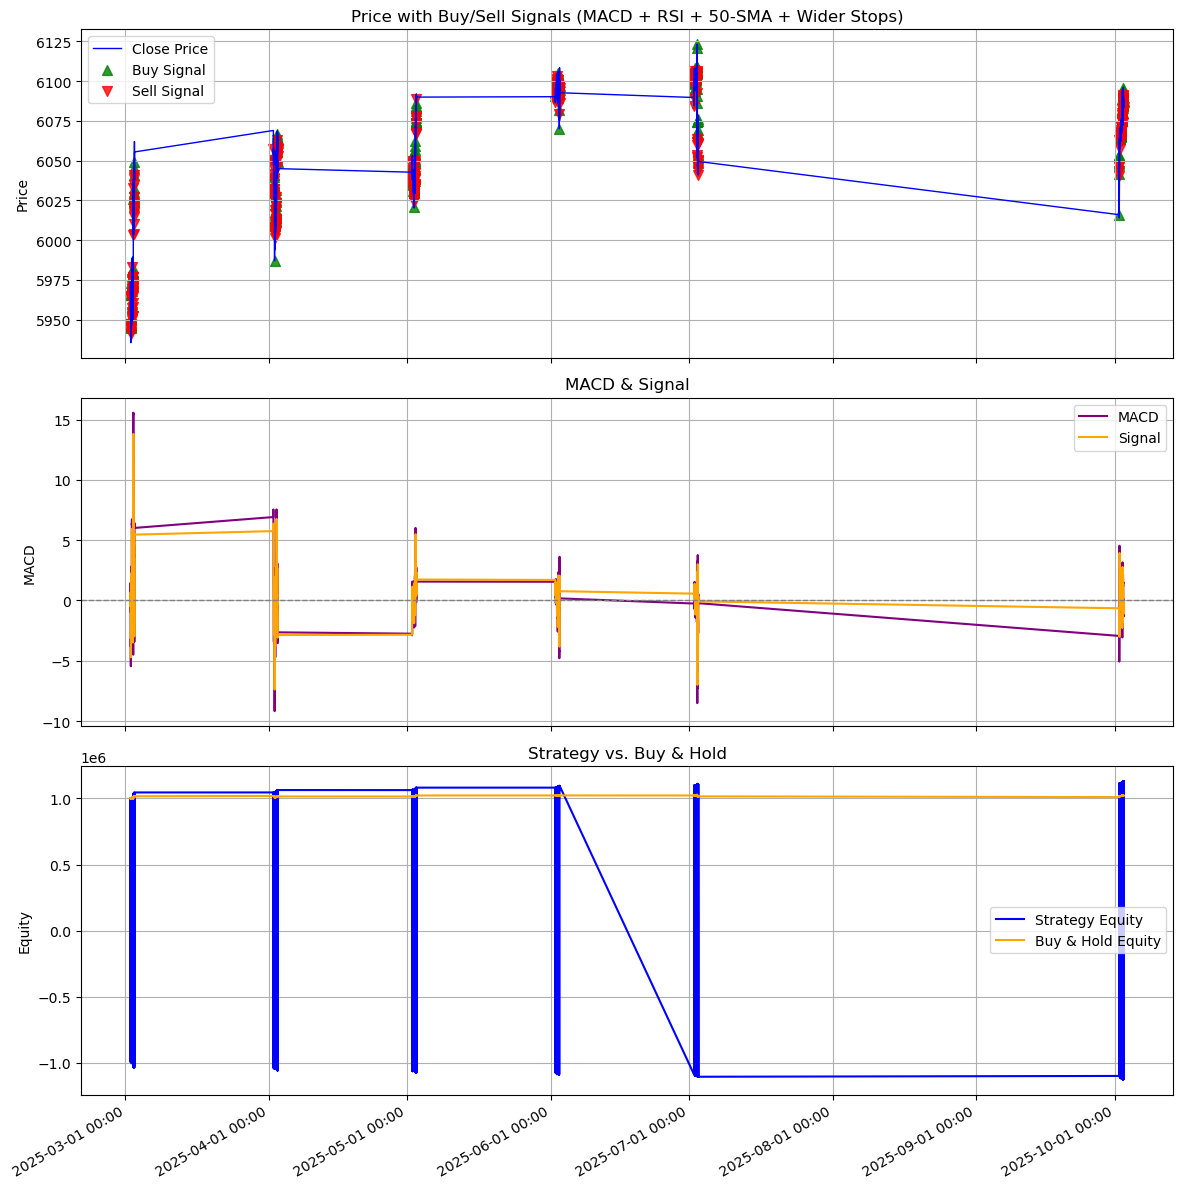

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates  # for better date formatting on x-axis

##############################################################################
# 1) READ & PREPARE DATA
##############################################################################
file_path = "/Users/oscarolsen/Desktop/Algorithmic Trading/Algorithmic-Trading/Stor pik.csv"

df = pd.read_csv(
    file_path,
    sep=";",          # Adjust if your CSV uses a different delimiter
    decimal=",",      # Interpret commas as decimal points (e.g., 6087,75 -> 6087.75)
    header=0          # If the first row is "Date;Last Price"
)

# Rename columns (assuming CSV header is "Date" and "Last Price")
df.rename(columns={"Date": "timestamp", "Last Price": "close"}, inplace=True)

# Convert timestamp to datetime, e.g., "02/10/25 22.54.22" -> DD/MM/YY HH.mm.ss
df["timestamp"] = pd.to_datetime(df["timestamp"], format="%d/%m/%y %H.%M.%S", errors="coerce")
df.dropna(subset=["timestamp"], inplace=True)
df.set_index("timestamp", inplace=True)

# Duplicate close price into open/high/low if needed for ATR
df["open"] = df["close"]
df["high"] = df["close"]
df["low"] = df["close"]

df.sort_index(inplace=True)

if len(df) == 0:
    raise ValueError("No rows were read from the CSV. Check delimiter/header/date format.")

##############################################################################
# 2) DEFINE HELPER FUNCTIONS: RSI, MACD, ATR
##############################################################################

def compute_rsi(series, period=14):
    """
    Calculate RSI (Relative Strength Index) manually.
    """
    delta = series.diff()
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def compute_macd(series, fast=12, slow=26, signal=9):
    """
    MACD = EMA(fast) - EMA(slow)
    Signal = EMA(MACD, signal)
    """
    ema_fast = series.ewm(span=fast, adjust=False).mean()
    ema_slow = series.ewm(span=slow, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()
    return macd_line, signal_line

def compute_atr(df, period=14):
    """
    Compute ATR (Average True Range).
    """
    df["H-L"] = df["high"] - df["low"]
    df["H-PC"] = (df["high"] - df["close"].shift(1)).abs()
    df["L-PC"] = (df["low"] - df["close"].shift(1)).abs()
    df["TR"] = df[["H-L", "H-PC", "L-PC"]].max(axis=1)
    df["ATR"] = df["TR"].rolling(window=period).mean()
    return df["ATR"]

##############################################################################
# 3) CALCULATE INDICATORS: MACD, RSI, ATR, 50-SMA
##############################################################################

# MACD (12, 26, 9)
df["MACD"], df["MACD_Signal"] = compute_macd(df["close"], fast=12, slow=26, signal=9)

# RSI (14)
df["RSI"] = compute_rsi(df["close"], period=14)

# ATR (14) - longer window
df["ATR"] = compute_atr(df, period=14)

# 50-SMA for trend filter
df["SMA_50"] = df["close"].rolling(window=50).mean()

# Drop rows that have NaNs in any critical column
df.dropna(subset=["RSI", "ATR", "SMA_50"], inplace=True)

##############################################################################
# 4) GENERATE ENTRY/EXIT SIGNALS WITH TREND FILTER
##############################################################################
# - Only go LONG if MACD>Signal, RSI<70, AND close > SMA_50
# - Only go SHORT if MACD<Signal, RSI>30, AND close < SMA_50

df["Position"] = 0
df.loc[
    (df["MACD"] > df["MACD_Signal"]) & 
    (df["RSI"] < 70) & 
    (df["close"] > df["SMA_50"]), 
    "Position"
] = 1

df.loc[
    (df["MACD"] < df["MACD_Signal"]) & 
    (df["RSI"] > 30) & 
    (df["close"] < df["SMA_50"]), 
    "Position"
] = -1

# "Trade_Signal" = change in Position
df["Trade_Signal"] = df["Position"].diff().fillna(0)

##############################################################################
# 5) BACKTEST: RISK-BASED POSITION SIZING + TRAILING STOP
##############################################################################

initial_cash = 1_000_000
cash = initial_cash
position = 0       # positive = long, negative = short
entry_price = None
stop_loss_price = None
trade_cost = 0
total_pnl = 0
trade_log = []
portfolio_value = []

# Proposed changes:
stop_loss_multiplier = 2.0  # Wider trailing stop
transaction_cost = 1.00
risk_per_trade_percent = 0.02

timestamps = df.index.tolist()

for i in range(len(df)):
    current_time = timestamps[i]
    price = df["close"].iloc[i]
    signal_val = df["Trade_Signal"].iloc[i]
    current_atr = df["ATR"].iloc[i]

    current_equity = cash + position * price

    # 1) Update trailing stop if we have a position
    if position > 0:  # LONG
        new_stop = price - stop_loss_multiplier * current_atr
        if stop_loss_price is None:
            stop_loss_price = new_stop
        else:
            # Ratchet up only
            stop_loss_price = max(stop_loss_price, new_stop)

        # Check if stop is triggered
        if price <= stop_loss_price:
            proceeds = position * price - transaction_cost
            trade_pnl = proceeds - trade_cost
            cash += proceeds
            total_pnl += trade_pnl
            trade_log.append(
                f"{current_time} - STOP LOSS LONG {position} @ {price:.2f} | PnL: ${trade_pnl:.2f}"
            )
            position = 0
            entry_price = None
            stop_loss_price = None
            trade_cost = 0

    elif position < 0:  # SHORT
        new_stop = price + stop_loss_multiplier * current_atr
        if stop_loss_price is None:
            stop_loss_price = new_stop
        else:
            # Ratchet down only
            stop_loss_price = min(stop_loss_price, new_stop)

        # Check if stop is triggered
        if price >= stop_loss_price:
            proceeds = abs(position) * price - transaction_cost
            trade_pnl = proceeds - trade_cost
            cash += proceeds
            total_pnl += trade_pnl
            trade_log.append(
                f"{current_time} - STOP LOSS SHORT {abs(position)} @ {price:.2f} | PnL: ${trade_pnl:.2f}"
            )
            position = 0
            entry_price = None
            stop_loss_price = None
            trade_cost = 0

    # 2) Check for new signals if we're flat
    if position == 0:
        if signal_val == 1:  # Potential BUY
            stop_distance = stop_loss_multiplier * current_atr
            if stop_distance > 0:
                risk_amount = risk_per_trade_percent * current_equity
                shares = int(risk_amount / stop_distance)
            else:
                shares = 0

            # Cap shares to what you can afford
            max_affordable_shares = int((cash - transaction_cost) // price)
            shares = min(shares, max_affordable_shares)

            cost_to_open = shares * price + transaction_cost
            if shares > 0 and cost_to_open <= cash:
                cash -= cost_to_open
                position = shares
                entry_price = price
                trade_cost = cost_to_open
                stop_loss_price = price - stop_distance
                trade_log.append(
                    f"{current_time} - BUY {shares} @ {price:.2f}"
                )

        elif signal_val == -1:  # Potential SHORT
            stop_distance = stop_loss_multiplier * current_atr
            if stop_distance > 0:
                risk_amount = risk_per_trade_percent * current_equity
                shares = int(risk_amount / stop_distance)
            else:
                shares = 0

            # Cap shares to what you can afford
            max_affordable_shares = int((cash - transaction_cost) // price)
            shares = min(shares, max_affordable_shares)

            cost_to_open = shares * price + transaction_cost
            if shares > 0 and cost_to_open <= cash:
                cash -= cost_to_open
                position = -shares
                entry_price = price
                trade_cost = cost_to_open
                stop_loss_price = price + stop_distance
                trade_log.append(
                    f"{current_time} - SHORT {shares} @ {price:.2f}"
                )

    # 3) Record portfolio value
    portfolio_value.append(cash + position * price)

# 4) If a position is open at the end, close it
if position != 0:
    final_price = df["close"].iloc[-1]
    if position > 0:
        proceeds = position * final_price - transaction_cost
        trade_pnl = proceeds - trade_cost
        cash += proceeds
        total_pnl += trade_pnl
        trade_log.append(
            f"{timestamps[-1]} - FINAL CLOSE LONG {position} @ {final_price:.2f} | PnL: ${trade_pnl:.2f}"
        )
    else:
        proceeds = abs(position) * final_price - transaction_cost
        trade_pnl = proceeds - trade_cost
        cash += proceeds
        total_pnl += trade_pnl
        trade_log.append(
            f"{timestamps[-1]} - FINAL CLOSE SHORT {abs(position)} @ {final_price:.2f} | PnL: ${trade_pnl:.2f}"
        )

    position = 0
    entry_price = None
    stop_loss_price = None
    trade_cost = 0

final_equity = cash
overall_pnl = final_equity - initial_cash

##############################################################################
# 6) BUY & HOLD COMPARISON
##############################################################################
buy_hold_shares = initial_cash / df["close"].iloc[0]
df["Buy_Hold_Value"] = buy_hold_shares * df["close"]
final_buy_hold = df["Buy_Hold_Value"].iloc[-1]
buy_hold_pnl = final_buy_hold - initial_cash

##############################################################################
# 7) PRINT RESULTS
##############################################################################
print("="*60)
print("FINAL TRADING SUMMARY")
print("="*60)
print(f"Total Trades Executed: {len(trade_log)}")
print(f"Strategy Final Equity: ${final_equity:,.2f}")
print(f"Strategy PnL:          ${overall_pnl:,.2f}")
print(f"Buy & Hold Final:      ${final_buy_hold:,.2f}")
print(f"Buy & Hold PnL:        ${buy_hold_pnl:,.2f}")
print("="*60)
print("Trade Log:")
for log_entry in trade_log:
    print(log_entry)

##############################################################################
# 8) IMPROVED VISUALIZATION: PRICE + SIGNALS, MACD, EQUITY
##############################################################################
df["Strategy_Value"] = portfolio_value
df["Close_Price"] = df["close"]

# Identify buy/sell signals for plotting
buy_signals = df[df["Trade_Signal"] == 1]
sell_signals = df[df["Trade_Signal"] == -1]

fig, axs = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# --- Subplot 1: Price with Buy/Sell Signals ---
axs[0].plot(df.index, df["Close_Price"], label="Close Price", color="blue", linewidth=1)
axs[0].scatter(
    buy_signals.index, 
    buy_signals["Close_Price"], 
    marker="^", 
    color="green", 
    s=50, 
    alpha=0.8, 
    label="Buy Signal"
)
axs[0].scatter(
    sell_signals.index, 
    sell_signals["Close_Price"], 
    marker="v", 
    color="red", 
    s=50, 
    alpha=0.8, 
    label="Sell Signal"
)
axs[0].set_ylabel("Price")
axs[0].set_title("Price with Buy/Sell Signals (MACD + RSI + 50-SMA + Wider Stops)")
axs[0].grid(True)
axs[0].legend()

# --- Subplot 2: MACD vs. MACD Signal ---
axs[1].plot(df.index, df["MACD"], label="MACD", color="purple")
axs[1].plot(df.index, df["MACD_Signal"], label="Signal", color="orange")
axs[1].axhline(0, color="grey", linewidth=1, linestyle="--")  # zero line
axs[1].set_ylabel("MACD")
axs[1].set_title("MACD & Signal")
axs[1].grid(True)
axs[1].legend()

# --- Subplot 3: Strategy vs. Buy & Hold Equity ---
axs[2].plot(df.index, df["Strategy_Value"], label="Strategy Equity", color="blue")
axs[2].plot(df.index, df["Buy_Hold_Value"], label="Buy & Hold Equity", color="orange")
axs[2].set_ylabel("Equity")
axs[2].set_title("Strategy vs. Buy & Hold")
axs[2].grid(True)
axs[2].legend()

# Format x-axis as dates
axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
fig.autofmt_xdate()  # rotate date labels

plt.tight_layout()
plt.show()
